In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_path = "/home/clairegayral/Documents/openclassroom/data/P3/"
res_path = "/home/clairegayral/Documents/openclassroom/res/P3/"

## my .py : 
import preprocess
import missing_values_treatment

from sklearn import model_selection 
from sklearn import preprocessing
from sklearn import neighbors
from sklearn.impute import KNNImputer


In [164]:
df_2015 = pd.read_csv(data_path+"2015-building-energy-benchmarking.csv", 
                          low_memory=False)#, index_col=0)
df_2016 = pd.read_csv(data_path+"2016-building-energy-benchmarking.csv", 
                          low_memory=False)#, index_col=0)

print("In 2015 data :", df_2015.shape[0],
      " buildings and ", df_2015.shape[1],"variables")
print("Total NaNs = ", df_2015.isna().sum().sum(), 
      "(that is ",np.round(100*df_2015.isna().sum().sum()/(
        df_2015.shape[0]*df_2015.shape[1]),2), "%)")

data = df_2015.loc[:,np.append(np.array(float_var),"OSEBuildingID")]

In 2015 data : 3340  buildings and  47 variables
Total NaNs =  26512 (that is  16.89 %)


## Prétraitement 
Les types semblent corrects (vérifiés avec df.dtypes). 

##### Gestion des doublons :

In [165]:
float_var = df_2015.loc[:,df_2015.dtypes==float].columns

data = df_2015.loc[:,np.append(np.array(float_var),"OSEBuildingID")]
dict_duplicates = preprocess.get_index_merge_duplicates(data, float_var, 1.15)
print(dict_duplicates)

{}


#####  Suppression colonnes vides :

In [166]:
##
## drop empty columns
##
data = df_2015.loc[:,float_var].set_index(df_2015["OSEBuildingID"])

nan_repartition = data.isna().sum(axis=0)
# nan_threshold = nan_repartition.mean()
nan_threshold = nan_repartition.quantile(0.95)
data = preprocess.preprocess_drop_col_nan(data, nan_threshold)

print("I drop variables with less than", 
      data.shape[0]-np.floor(nan_threshold),
      "values")
print("That is more than", 
      np.floor(nan_threshold),
      "missing values")
print("I have dropped", len(float_var)- data.shape[1] + 2,
      "variables :",
      float_var[[var not in data.columns for var in float_var]])

I drop variables with less than 258.0 values
That is more than 3082.0 missing values
I have dropped 4 variables : Index(['2010 Census Tracts', 'City Council Districts'], dtype='object')


In [167]:
float_var = data.columns[[var not in ["ENERGYSTARScore", "OSEBuildingID"] for var in data.columns]]
X = data[float_var]
y = data["ENERGYSTARScore"]


##### Inférence valeurs manquantes : 

MSE = 135.935 (+/-38.467) for {'n_neighbors': 1}
MSE = 120.461 (+/-28.644) for {'n_neighbors': 2}
MSE = 117.229 (+/-26.869) for {'n_neighbors': 3}
MSE = 116.259 (+/-25.837) for {'n_neighbors': 4}
MSE = 116.062 (+/-25.552) for {'n_neighbors': 5}
MSE = 115.993 (+/-25.230) for {'n_neighbors': 6}
MSE = 116.116 (+/-24.540) for {'n_neighbors': 7}
MSE = 116.330 (+/-24.327) for {'n_neighbors': 8}
MSE = 116.673 (+/-24.380) for {'n_neighbors': 9}
MSE = 116.850 (+/-23.925) for {'n_neighbors': 10}
MSE = 117.089 (+/-24.069) for {'n_neighbors': 11}
MSE = 117.315 (+/-23.802) for {'n_neighbors': 12}
MSE = 117.521 (+/-23.649) for {'n_neighbors': 13}
MSE = 117.590 (+/-23.487) for {'n_neighbors': 14}
MSE = 117.703 (+/-23.244) for {'n_neighbors': 15}
MSE = 117.813 (+/-23.207) for {'n_neighbors': 16}
MSE = 117.966 (+/-23.180) for {'n_neighbors': 17}
MSE = 118.073 (+/-23.063) for {'n_neighbors': 18}
MSE = 118.186 (+/-23.255) for {'n_neighbors': 19}
MSE = 118.267 (+/-23.175) for {'n_neighbors': 20}
MSE = 118

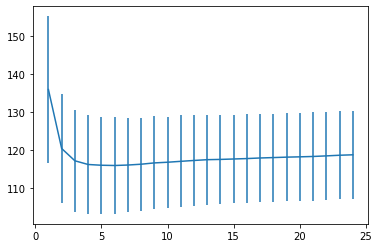

In [151]:
##
## Standardize X : 
##

standardizer = preprocessing.StandardScaler().fit(X)
X_std = standardizer.transform(X)
X_std = pd.DataFrame(X_std, columns= X.columns, index = X.index)

##
## Set the best number of neighbors
##

my_meth = KNNImputer
param_grid = {"n_neighbors" : np.arange(1,25,1)}
cv = 3

res = missing_values_treatment.launch_my_pseudo_CV(X_std,my_meth,param_grid, cv = cv)

# Save dictionnary of results : 
import pickle
with open(res_path+"set_n_KNN_impute"+".pkl", "wb") as f :
    pickle.dump(res, f, pickle.HIGHEST_PROTOCOL)

# import pickle
# with open(res_path+"set_n_KNN_impute"+".pkl", "rb") as f :
#         res = pickle.load(f)

## plot MSE scores :
MSE_mean = []
MSE_std = []

for params_set in res.keys(): 
    dict_y_table = res[params_set]
    
    MSE = missing_values_treatment.compute_dict_MSE(dict_y_table)
    MSE_mean.append(MSE.mean())
    MSE_std.append(MSE.std())

params = []
for kwargs in model_selection.ParameterGrid(param_grid) :
    params.append(kwargs)

CV_results_ = {"params": params , "mean_MSE_score":MSE_mean, "std_MSE_score":MSE_std}

iterator = zip(CV_results_["mean_MSE_score"], CV_results_["std_MSE_score"], CV_results_["params"])
for mean, std, params in iterator:
    print("MSE = %0.3f (+/-%0.3f) for %s" %(mean, 2*std, params))

fig, ax = plt.subplots()
ax.errorbar(x=param_grid["n_neighbors"], y=np.array(CV_results_["mean_MSE_score"]),
            xerr=0, yerr=np.array(CV_results_["std_MSE_score"]))
plt.show()

In [150]:
## Impute missing values :
imputer = KNNImputer(n_neighbors=4)
pred_std = imputer.fit_transform(X_std)
pred_std = pd.DataFrame(pred_std, index = X.index, columns = X.columns)

## Inverse-standardize : 
# pred_std = pd.read_csv(res_path+"dataframe_std_KNN_impute.csv",index_col=0)
pred = standardizer.inverse_transform(pred_std)
pred = pd.DataFrame(pred, index = X.index, columns = X.columns)


##### Retrait des bâtiments sans le score : 

In [169]:
data["ENERGYSTARScore"]

OSEBuildingID
1        65.0
2        51.0
3        18.0
5         1.0
8        67.0
         ... 
50049    71.0
50055    98.0
50057    79.0
50058    44.0
50059    24.0
Name: ENERGYSTARScore, Length: 3340, dtype: float64

In [204]:
index_to_drop = data[data["ENERGYSTARScore"].isna().values].index
data = data.drop(index_to_drop,axis=0)

X = data[float_var]
X_pred = pred.drop(index_to_drop,axis=0)
y = data["ENERGYSTARScore"]

## Etude des variables descriptives numériques

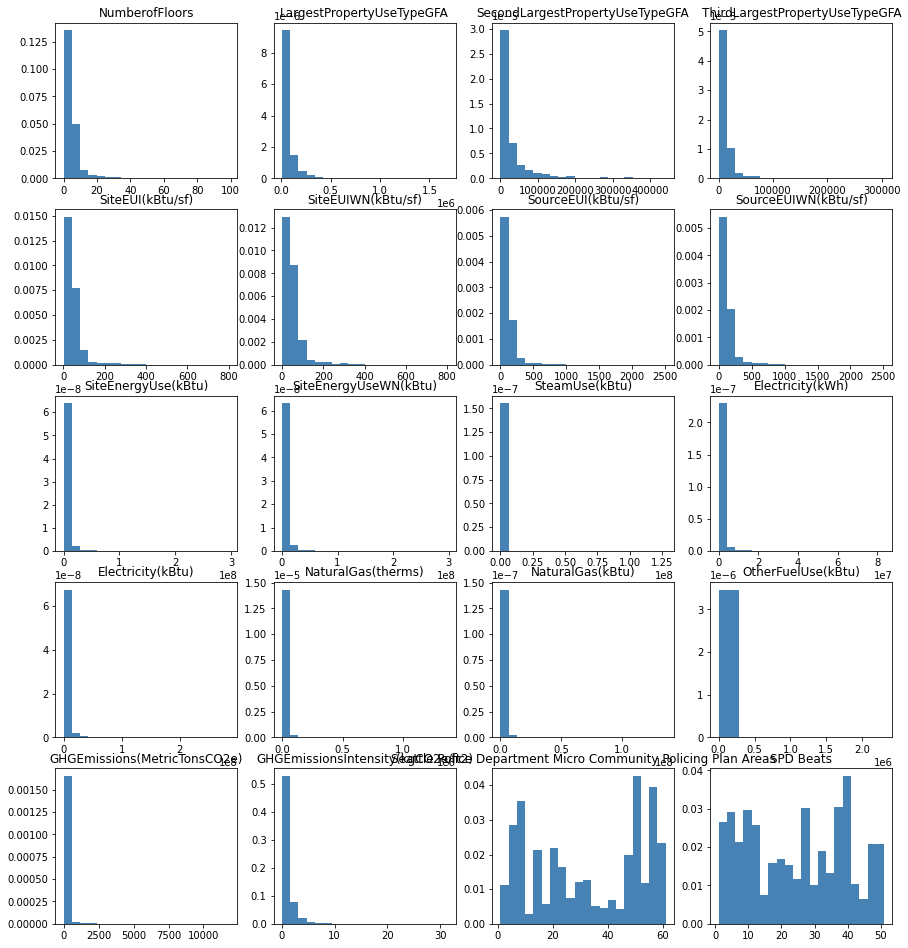

In [205]:
nb_line_plot = int(np.floor(len(float_var)/4)+1)
fig = plt.figure(figsize=(15, 20))

fig_count = 1
for var in float_var :#data.columns.intersection(list_of_nutri_facts):
    ax = fig.add_subplot(nb_line_plot,4, fig_count)
    nb_bins = min(20, len(np.unique(data[var].dropna().values)))
    ax.hist(data[var], bins = nb_bins, color='steelblue', density=True, edgecolor='none')
    ax.set_title(var)
    fig_count += 1
plt.show()

## Etude de la variable de réponse 

count    2560.000000
mean       67.894141
std        27.154057
min         1.000000
25%        51.750000
50%        76.000000
75%        90.000000
max       100.000000
Name: ENERGYSTARScore, dtype: float64

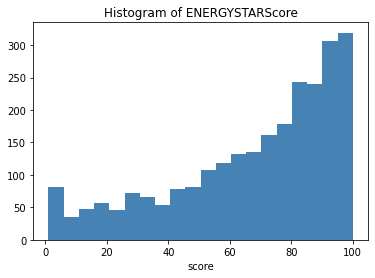

In [201]:
nb_bins = min(20, len(np.unique(y.values)))
plt.hist(y, bins = nb_bins, color='steelblue', edgecolor='none')
plt.title("Histogram of "+y.name)
plt.xlabel("score")
y.describe()

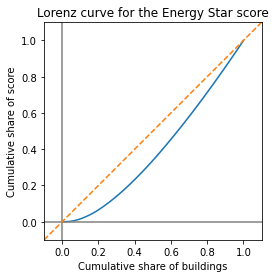

gini = 0.22380585297213407
AUC = 0.38809707351393297


In [181]:
## lorenz curve : 
import numpy as np

n = len(y)
y_rescaled = y - min(y)
lorenz = np.cumsum(np.sort(y_rescaled)) / y_rescaled.sum()
lorenz = np.append([0],lorenz) # La courbe de Lorenz commence à 0

fig, ax = plt.subplots()

ax.axis('scaled')
xaxis = np.linspace(0-1/n,1+1/n,n+1) 
plt.plot(xaxis,lorenz,drawstyle='steps-post')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.plot([0,0],[-0.1,1.1], color="grey") # y axis 
plt.plot([-0.1,1.1],[0,0], color="grey") # x axis
plt.plot([-0.1,1.1],[-0.1,1.1], "--") # identity line

plt.xlabel("Cumulative share of buildings")
plt.ylabel("Cumulative share of score")
plt.title("Lorenz curve for the Energy Star score")

plt.show()

AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n # Surface sous la courbe de Lorenz. Le premier segment (lorenz[0]) est à moitié en dessous de 0, on le coupe donc en 2, on fait de même pour le dernier segment lorenz[-1] qui est à moitié au dessus de 1.
S = 0.5 - AUC # surface entre la première bissectrice et le courbe de Lorenz
gini = 2*S
print("gini =", gini)
print("AUC =", AUC)